In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


初始化数据


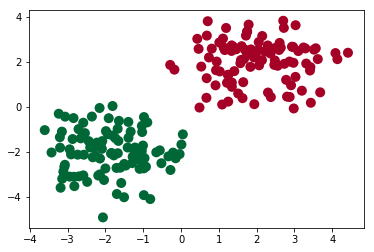

In [3]:
# make fake data
n_data = torch.ones(100, 2)
# torch.normal(means, std, out=None)
# 返回一个张量，包含从给定参数means,std的离散正态分布中抽取随机数。 均值means是一个张量，包含每个输出元素相关的正态分布的均值。
# std是一个张量，包含每个输出元素相关的正态分布的标准差。 均值和标准差的形状不须匹配，但每个张量的元素个数须相同。
# parameter:
# means (Tensor) – 均值
# std (Tensor) – 标准差
# out (Tensor) – 可选的输出张量
# x0产生均值为2，标准差为1的随机数
x0 = torch.normal(2*n_data, 1)      # class0 x data (tensor), shape=(100, 2)
# y0为x0的标签，表示0类
y0 = torch.zeros(100)               # class0 y data (tensor), shape=(100, 1)
# x1产生均值为2，标准差为1的随机数
x1 = torch.normal(-2*n_data, 1)     # class1 x data (tensor), shape=(100, 2)
# y1为x1的标签，表示1类
y1 = torch.ones(100)                # class1 y data (tensor), shape=(100, 1)
# 将向量拼接，参数0表示按行拼接，增加行，参数1表示按列拼接，增加列默认为0
x = torch.cat((x0, x1), 0).type(torch.FloatTensor)  # shape (200, 2) FloatTensor = 32-bit floating
y = torch.cat((y0, y1),).type(torch.LongTensor)    # shape (200,) LongTensor = 64-bit integer

plt.scatter(x.numpy()[:, 0], x.numpy()[:, 1], c=y.numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()


定义网络模型

In [4]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.out = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.out(x)
        return x
# n_output表示输出，有5类就会输出[x1,x2,x3,x4,x5]，其中只有一个为1，表示分到该类，实际上是为独热编码
net = Net(n_feature=2, n_hidden=10, n_output=2)     # define the network
print(net)  # net architecture


Net(
  (hidden): Linear(in_features=2, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=2, bias=True)
)


定义优化器和损失函数，损失函数使用交叉熵，自带softmax

In [5]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.02)
# 分类问题用交叉熵，里面自带softmax概率计算，例如有5类输出，则他输出的5个概率之和为1，其中最大的即表示他分类结果
# 通过预测结果和真实结果的独热编码进行交叉熵计算
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted


计算+绘图

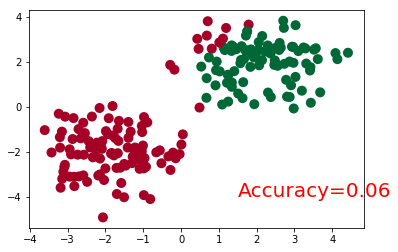

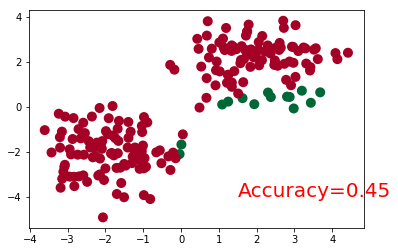

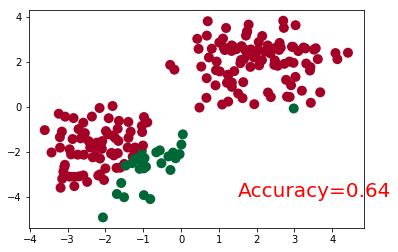

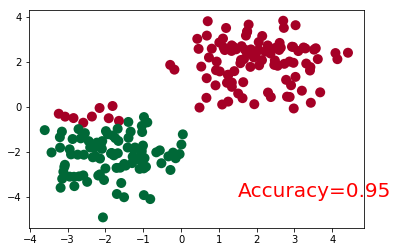

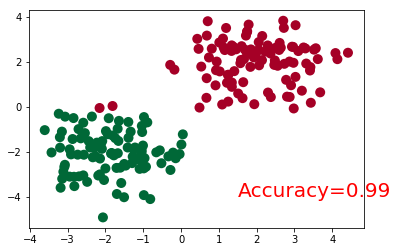

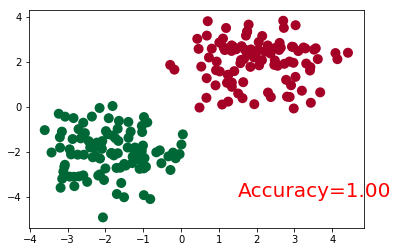

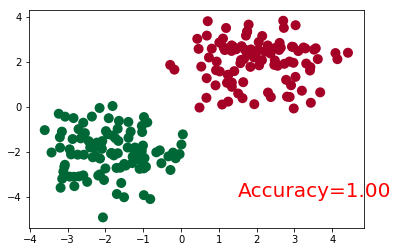

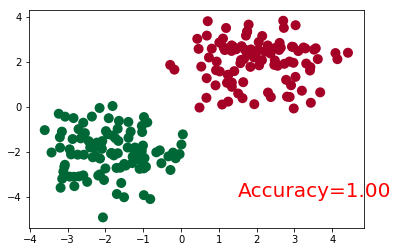

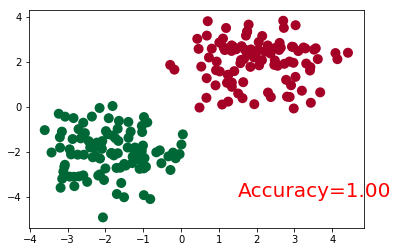

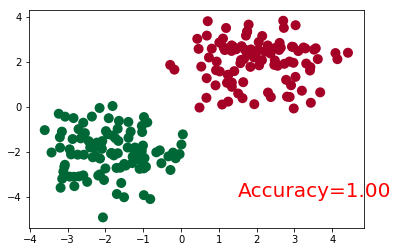

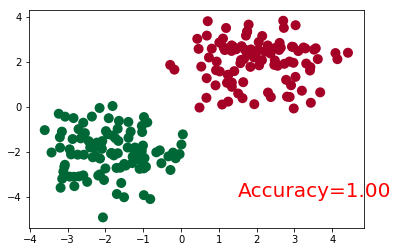

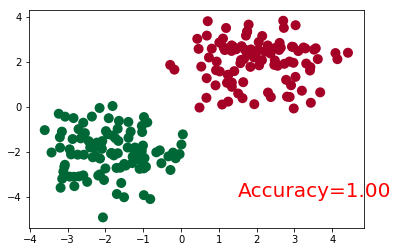

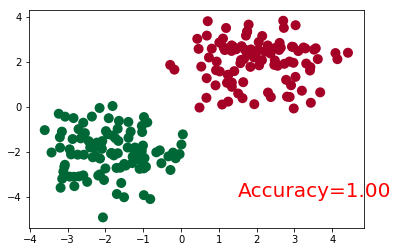

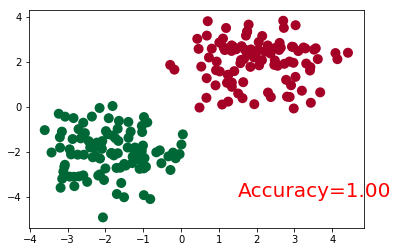

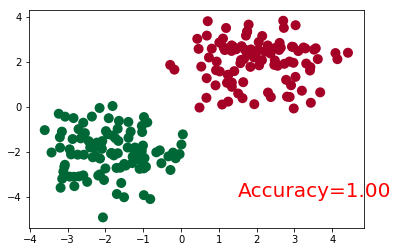

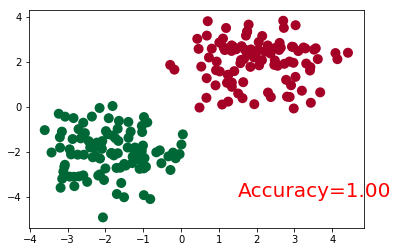

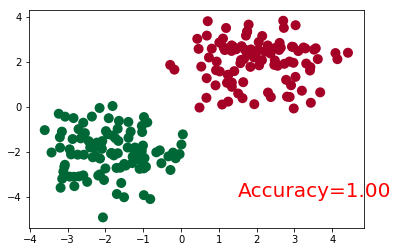

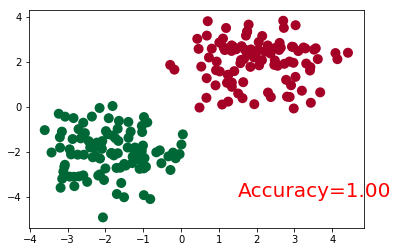

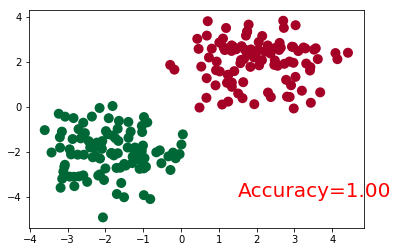

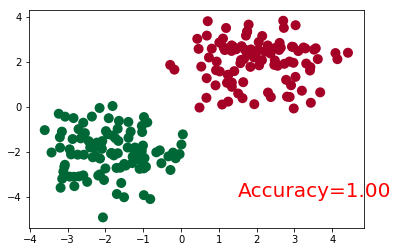

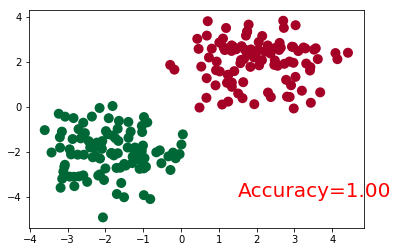

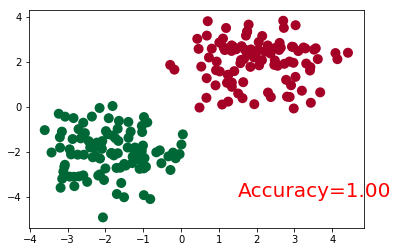

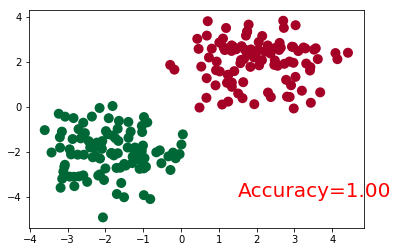

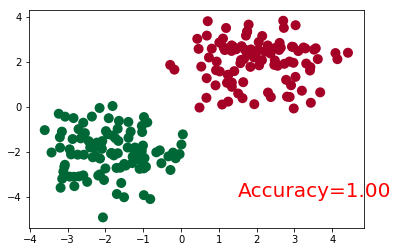

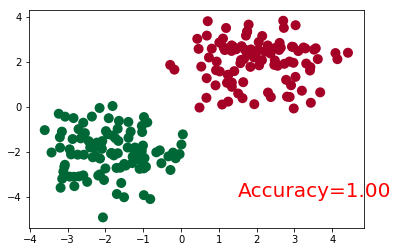

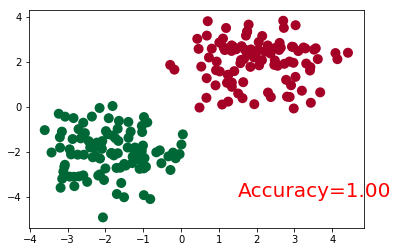

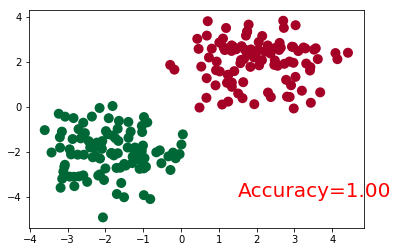

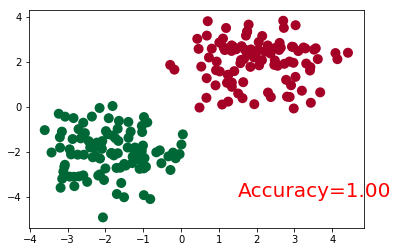

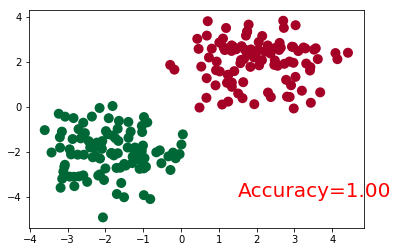

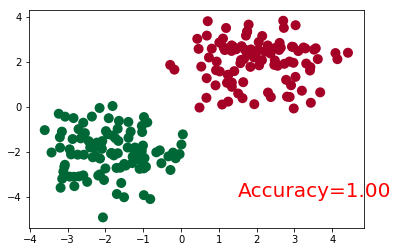

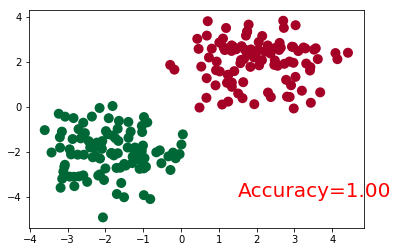

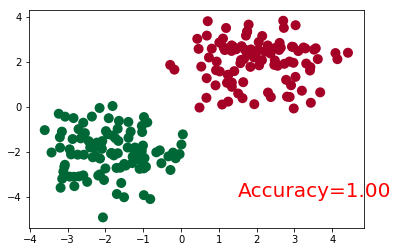

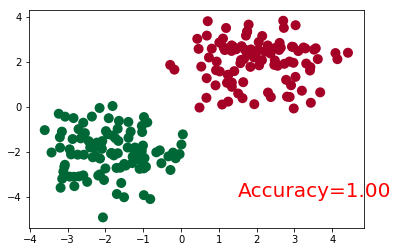

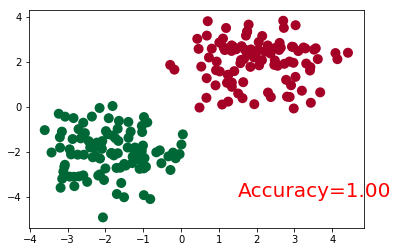

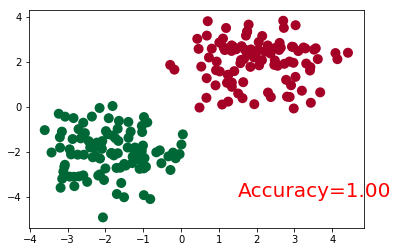

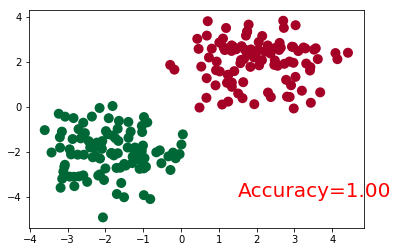

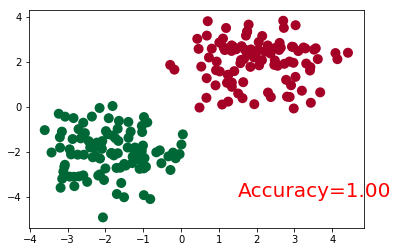

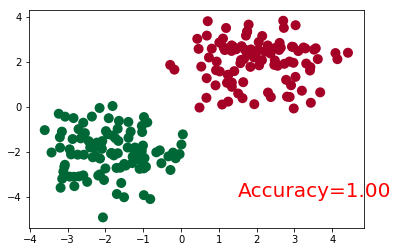

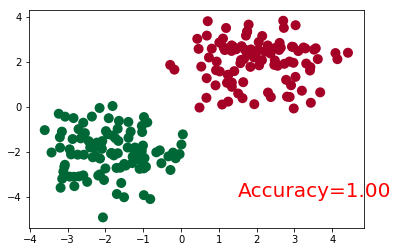

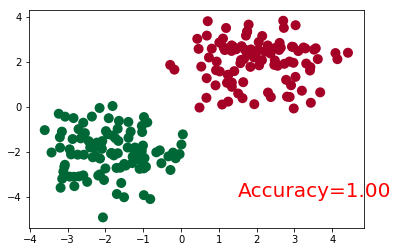

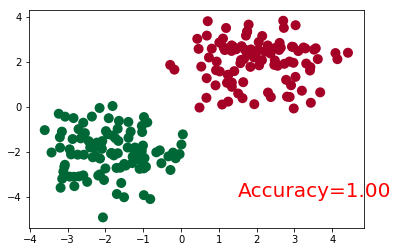

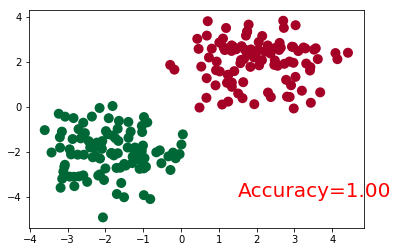

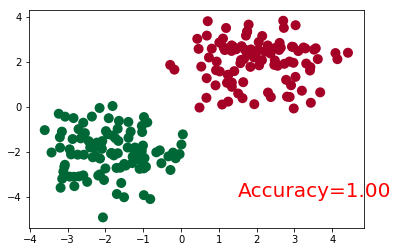

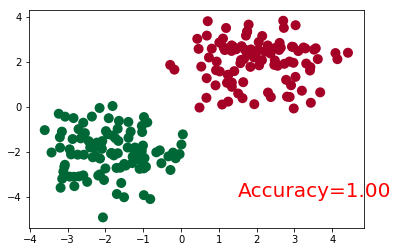

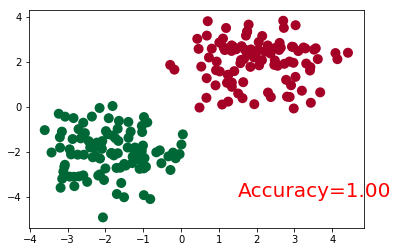

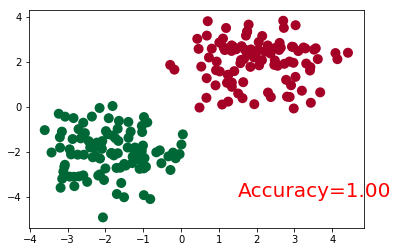

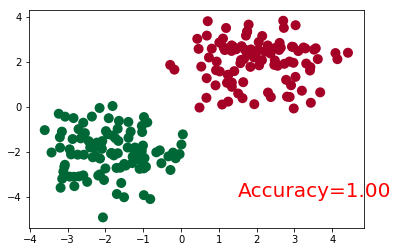

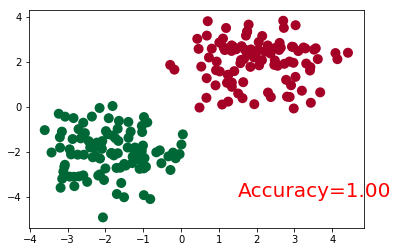

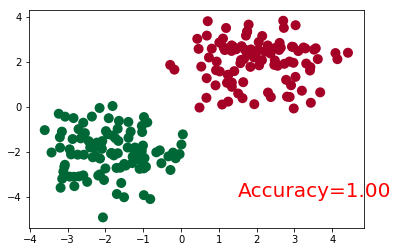

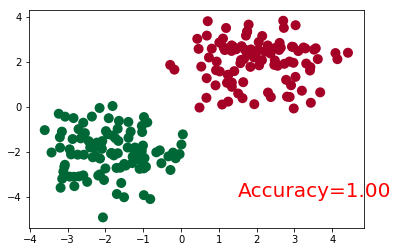

In [6]:
plt.ion()   # something about plotting

for t in range(100):
    out = net(x)                 # input x and predict based on x
    loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t % 2 == 0:
        # plot and show learning process
        plt.cla()
        # torch.max(a,0) 返回每一列中最大值的那个元素，且返回其索引（返回最大元素在这一列的行索引）
        # torch.max(a,1) 返回每一行中最大值的那个元素，且返回其索引（返回最大元素在这一行的列索引）
        prediction = torch.max(out, 1)[1]
        pred_y = prediction.numpy()
        target_y = y.numpy()
        plt.scatter(x.numpy()[:, 0], x.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = float((pred_y == target_y).astype(int).sum()) / float(target_y.size)
        plt.text(1.5, -4, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()




模型保存

In [7]:
torch.save(net.state_dict(), './mofan_classification.pth')
